# Results and figures included in the paper

This notebook presents the figures -and the code required to reproduce them- included in the paper.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import pysal as ps
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import sklearn.model_selection as cv
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.decomposition import FactorAnalysis, PCA

sns.set(style="whitegrid")

## Modelling

In [2]:
db = gpd.read_file('../data/satellite_features_lsoa_liv.geojson').set_index('LSOA11CD')
factors_jc = pd.read_csv('../data/Variables_PCF.csv', index_col=0)[['f1', 'f2', 'f3', 'f4']]

lu = ['p_veg', 'p_b_water', 'p_shadow']
lu_all = [i for i in db.columns if i[:2]=='p_'] + ['f_or_imp_s']
fetex = [i for i in db.columns if (i[0]==i[0].upper()) and (i!='IDfetex')]

### OLS

In [3]:
xy = db[['living_env'] + lu].join(factors_jc)
y = 'living_env'

m1 = ps.spreg.OLS(xy[[y]].values, xy.drop(y, axis=1).values, \
                    name_y=y, name_x=xy.drop(y, axis=1).columns.values.tolist())
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  living_env                Number of Observations:         298
Mean dependent var  :     37.1393                Number of Variables   :           8
S.D. dependent var  :     17.3660                Degrees of Freedom    :         290
R-squared           :      0.3440
Adjusted R-squared  :      0.3282
Sum squared residual:   58755.056                F-statistic           :     21.7272
Sigma-square        :     202.604                Prob(F-statistic)     :   1.582e-23
S.E. of regression  :      14.234                Log likelihood        :   -1210.165
Sigma-square ML     :     197.165                Akaike info criterion :    2436.331
S.E of regression ML:     14.0415                Schwarz criterion     :    2465.908

-----------------------------------------------------------------------------

### GMM-Lag

In [4]:
xy = db[['living_env'] + lu].join(factors_jc)
y = 'living_env'

w = ps.weights.Queen.from_dataframe(db)
w.transform = 'R'

m2 = ps.spreg.ML_Lag(xy[[y]].values, xy.drop(y, axis=1).values, w, \
                    name_y=y, name_x=xy.drop(y, axis=1).columns.values.tolist())
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  living_env                Number of Observations:         298
Mean dependent var  :     37.1393                Number of Variables   :           9
S.D. dependent var  :     17.3660                Degrees of Freedom    :         289
Pseudo R-squared    :      0.6186
Spatial Pseudo R-squared:  0.4327
Sigma-square ML     :     115.921                Log likelihood        :   -1145.809
S.E of regression   :      10.767                Akaike info criterion :    2309.618
                                                 Schwarz criterion     :    2342.892

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/dani/anaconda/envs/gds/lib/python3.5/site-packages/scipy/optimize/_minimize.py:600: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


### Estimates table

In [5]:
res1 = pd.DataFrame({('OLS', 'Coef.'): m1.betas.flatten(), \
                     ('OLS', 'P-Val'): [i[1] for i in m1.t_stat]}, \
                    index=m1.name_x)
res2 = pd.DataFrame({('GMM', 'Coef.'): m2.betas.flatten(), \
                     ('GMM', 'P-Val'): [i[1] for i in m2.z_stat]}, \
                    index=m2.name_x)
res = pd.concat([res1, res2], axis=1)
tab = np.round(res, 4).replace(np.nan, '')
tab

OLS              GMM        
                Coef.   P-Val    Coef.   P-Val
CONSTANT      65.0581  0.0003  44.6907  0.0011
W_living_env                    0.6504  0.0000
f1            -1.7557  0.3315  -3.0328  0.0264
f2            -2.6794  0.1764  -2.1430  0.1526
f3             3.2969  0.0003   2.0437  0.0036
f4            -2.0457  0.0209  -1.3078  0.0497
p_b_water      -3.246       0  -1.8888  0.0005
p_shadow      -0.0983  0.7794  -0.3728  0.1599
p_veg          -0.644  0.0075  -0.5402  0.0029

### Random Forest

In [6]:
np.random.seed(1234)
xy = db[lu_all + fetex]

rf = RandomForestRegressor(n_estimators=100)
%time trained = rf.fit(xy, db['living_env'])
rfy_all = pd.Series(rf.predict(xy), index=xy.index)

CPU times: user 415 ms, sys: 11.2 ms, total: 426 ms
Wall time: 463 ms


* $R^2$

In [7]:
rf_r2_of = skl.metrics.r2_score(db['living_env'], rfy_all)
rf_r2_of

0.93540185391683295

* Feature relevance plot

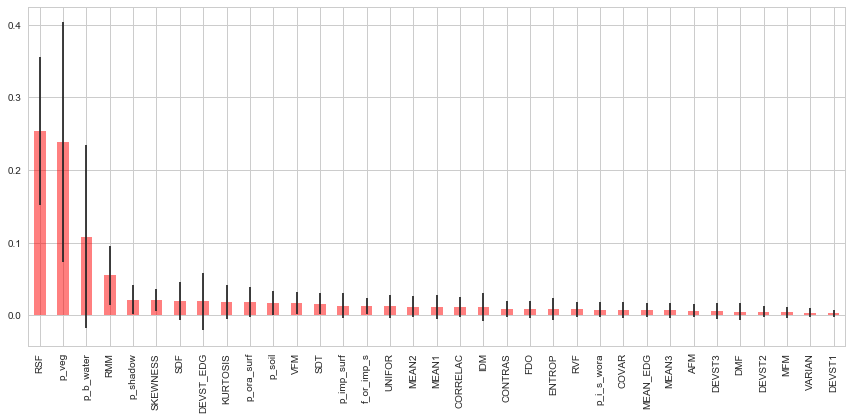

In [8]:
# Prep
trained = rf.fit(xy, db['living_env'])
importances = rf.feature_importances_
feat_std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
rel = pd.DataFrame({'importance': importances, 'std': feat_std}, index=xy.columns)\
        .sort_values('importance', ascending=False)
# Plot
f, ax = plt.subplots(1, figsize=(12, 6))
rel['importance'].plot(kind='bar', linewidth=0, ax=ax, alpha=0.5, \
                            color='red', yerr=rel['std'])
plt.tight_layout()

plt.show()

### Gradient Boost Regressor

**NOTE**: We select both the loss function and the learning rate using 5-fold cross-validation.

In [9]:
np.random.seed(1234)

xy = db[lu_all + fetex]

params = {'n_estimators': 100, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.035, 'loss': 'lad'}
gbr = GradientBoostingRegressor(**params)
%time trained = gbr.fit(xy, db['living_env'])
gbr_all = pd.Series(gbr.predict(xy), index=xy.index)

CPU times: user 134 ms, sys: 935 µs, total: 135 ms
Wall time: 137 ms


* $R^2$

In [10]:
gbr_r2_of = skl.metrics.r2_score(db['living_env'], gbr_all)
gbr_r2_of

0.83195172080594837

* Feature relevance

**NOTE**: not included in the paper because it is virtually the same as for the random forest.

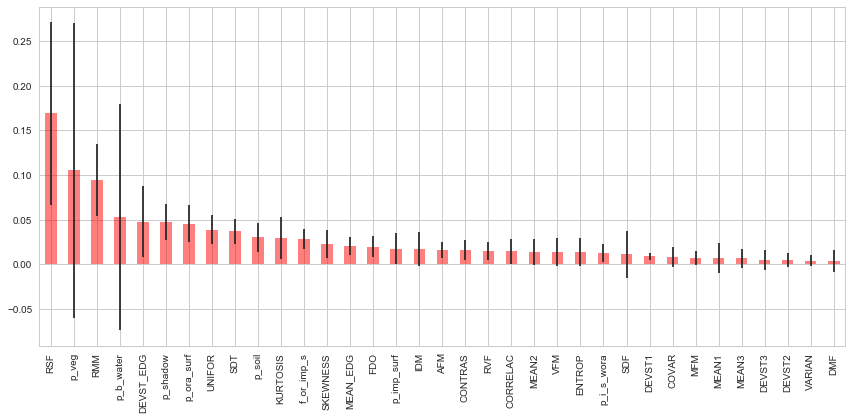

In [11]:
# Prep
trained = gbr.fit(xy, db['living_env'])
importances = gbr.feature_importances_
feat_std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
rel = pd.DataFrame({'importance': importances, 'std': feat_std}, index=xy.columns)\
        .sort_values('importance', ascending=False)
# Plot
f, ax = plt.subplots(1, figsize=(12, 6))
rel['importance'].plot(kind='bar', linewidth=0, ax=ax, alpha=0.5, \
                            color='red', yerr=rel['std'])
plt.tight_layout()

* Partial Dependence Plots

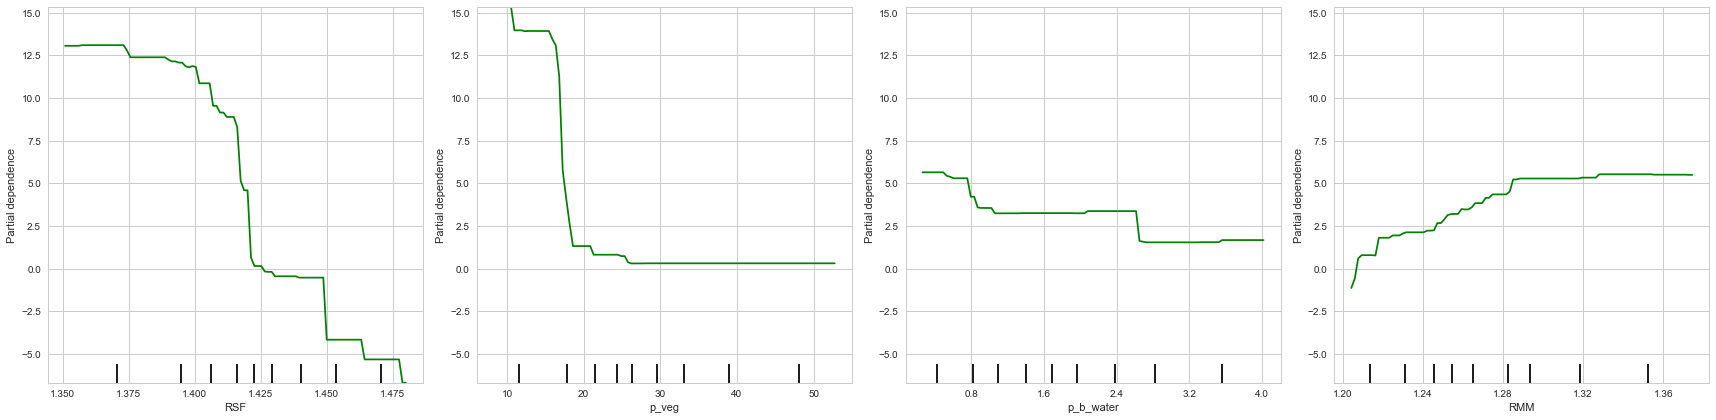

In [12]:
np.random.seed(1234)

names = ['RSF', 'p_veg', 'p_b_water', 'RMM']
cols = xy.columns.values.tolist()
ids = [cols.index(i) for i in names]

fig, axs = skl.ensemble.partial_dependence.plot_partial_dependence(
                    gbr, xy, ids, feature_names=xy.columns.values.tolist(),
                    n_jobs=-1, n_cols=4, \
                    figsize=(24, 6))
plt.tight_layout()

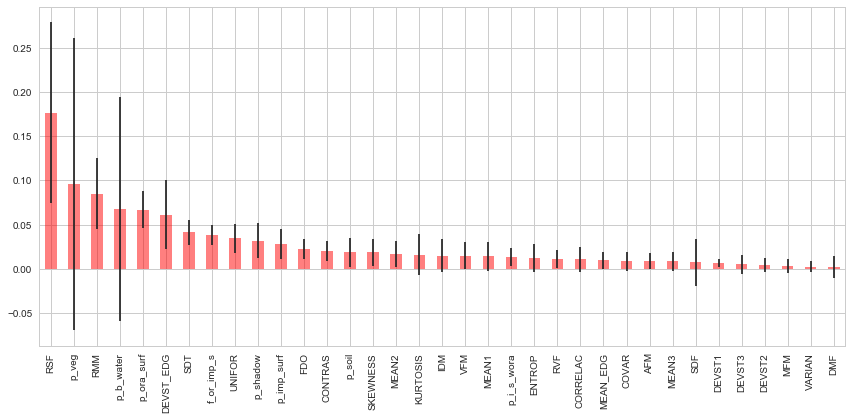

In [13]:
# Prep
trained = gbr.fit(xy, db['living_env'])
importances = gbr.feature_importances_
feat_std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
rel = pd.DataFrame({'importance': importances, 'std': feat_std}, index=xy.columns)\
        .sort_values('importance', ascending=False)
# Plot
f, ax = plt.subplots(1, figsize=(12, 6))
rel['importance'].plot(kind='bar', linewidth=0, ax=ax, alpha=0.5, \
                            color='red', yerr=rel['std'])
plt.tight_layout()

## Cross-validation

* Raw $R^2$

In [14]:
r2 = pd.Series({'OLS':m1.r2, 'GMM':m2.pr2_e, \
                'RF': rf_r2_of, 'GBR': gbr_r2_of})\
            .sort_values(ascending=False)
r2

RF     0.935402
GBR    0.831952
GMM    0.432687
OLS    0.344026
dtype: float64

* Cross-validated $R^2$

In [15]:
%%time

np.random.seed(1234)

xy = db[lu_all].join(factors_jc)
x_all = db[lu_all + fetex]

ols = skl.linear_model.LinearRegression()
rf = RandomForestRegressor(n_estimators=100)
gbr = GradientBoostingRegressor(n_estimators=100, \
                                max_depth=4, \
                                min_samples_split=2, \
                                learning_rate=0.035, \
                                loss='lad')

scores = []
for i in range(250):
    # Split dataset
    x_train, x_test, y_train, y_test = cv.train_test_split(x_all, db['living_env'], \
                test_size=0.4, random_state=i)
    # RF w/ all variables
    rfer_all = rf.fit(x_train, y_train)
    rf_all_predy = rfer_all.predict(x_test)
    rf_all_r2 = skl.metrics.r2_score(y_test, rf_all_predy)    
    # GBR w/ all variables
    gbr_all = gbr.fit(x_train, y_train)
    gbr_all_predy = gbr_all.predict(x_test)
    gbr_all_r2 = skl.metrics.r2_score(y_test, gbr_all_predy)
    # Land-use + Juanca variables
    x_train, x_test, y_train, y_test = cv.train_test_split(xy, db['living_env'], \
                test_size=0.4, random_state=i)
    # OLS
    olser = ols.fit(x_train, y_train)
    ols_predy = olser.predict(x_test)
    ols_r2 = skl.metrics.r2_score(y_test, ols_predy)

    
    scores.append((ols_r2, rf_all_r2, gbr_all_r2))
scores = pd.DataFrame(np.array(scores), columns=['OLS', 'RF', 'GBR'])

CPU times: user 1min 25s, sys: 408 ms, total: 1min 26s
Wall time: 1min 38s


Median values
RF     0.538313
GBR    0.496046
OLS    0.317247
dtype: float64


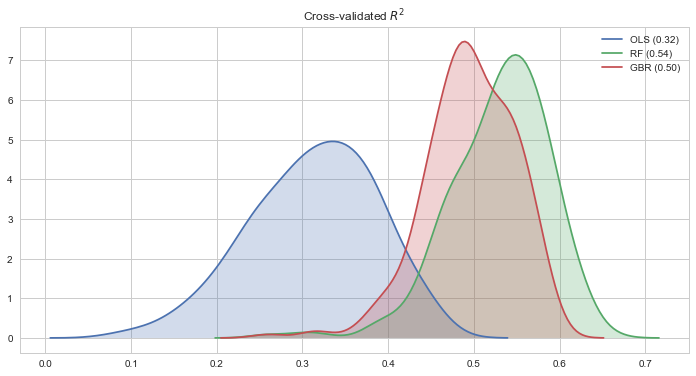

In [16]:
print('Median values')
print(scores.median().sort_values(ascending=False))
f, ax = plt.subplots(1, figsize=(12, 6))
for col in scores:
    med = scores[col].median()
    sns.kdeplot(scores[col], ax=ax, shade=True, \
               label="%s (%.2f)"%(col, med))
plt.title('Cross-validated $R^2$');